In [0]:
%matplotlib inline

In [0]:
!pip install --upgrade efficientnet-pytorch

In [4]:
!rm -r tiny-imagenet-200
!curl http://cs231n.stanford.edu/tiny-imagenet-200.zip -O tiny-imagenet-200.zip
!unzip -qq tiny-imagenet-200.zip

rm: cannot remove 'tiny-imagenet-200': No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  236M  100  236M    0     0  84.1M      0  0:00:02  0:00:02 --:--:-- 84.1M
curl: (6) Could not resolve host: tiny-imagenet-200.zip


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [6]:
from __future__ import print_function 
from __future__ import division
from efficientnet_pytorch import EfficientNet
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import io
import pandas as pd
import glob
import os
from shutil import move
from os.path import join
from os import listdir, rmdir

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True, advprop=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    elif model_name.startswith("efficientnet"):
        model_ft = EfficientNet.from_pretrained(model_name, advprop=advprop)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft._fc.in_features
        model_ft._fc = nn.Linear(num_ftrs, num_classes)
        input_sizes = {
            'efficientnet-b0': 224,
            'efficientnet-b1': 240,
            'efficientnet-b2': 260,
            'efficientnet-b3': 300,
            'efficientnet-b4': 380,
            'efficientnet-b5': 456,
            'efficientnet-b6': 528,
            'efficientnet-b7': 600,
            }
        input_size = input_sizes[model_name]

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.5.0+cu101
Torchvision Version:  0.6.0+cu101


In [0]:
target_folder = './tiny-imagenet-200/val/'

val_dict = {}
with open(target_folder + 'val_annotations.txt', 'r') as f:
    for line in f.readlines():
        split_line = line.split('\t')
        val_dict[split_line[0]] = split_line[1]
        
paths = glob.glob(target_folder + 'images/*')
paths[0].split('/')[-1]
for path in paths:
    file = path.split('/')[-1]
    folder = val_dict[file]
    if not os.path.exists(target_folder + str(folder)):
        os.mkdir(target_folder + str(folder))
        
for path in paths:
    file = path.split('/')[-1]
    folder = val_dict[file]
    dest = target_folder + str(folder) + '/' + str(file)
    move(path, dest)
    
os.remove('./tiny-imagenet-200/val/val_annotations.txt')
rmdir('./tiny-imagenet-200/val/images')

Visualization
-----------------------------------


Credits: https://github.com/WillKoehrsen/pytorch_challenge/blob/master/Transfer%20Learning%20in%20PyTorch.ipynb

In [8]:
data_dir = "./tiny-imagenet-200"
model_name = "efficientnet-b4" # change accordingly
model_output = "{}_chkpt_last_epoch".format(model_name) # change accordingly
num_classes = 200
batch_size = 16 # change if CUDA memory low
feature_extract = False

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: ImageFolderWithPaths(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_ft = model_ft.to(device)

model_ft.load_state_dict(torch.load(F"/content/drive/My Drive/{model_output}"))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b4-44fb3a87.pth" to /root/.cache/torch/checkpoints/adv-efficientnet-b4-44fb3a87.pth



Loaded pretrained weights for efficientnet-b4
Initializing Datasets and Dataloaders...


<All keys matched successfully>

In [9]:
target_folder = './tiny-imagenet-200/'
classes_human_readable = {}
with open(target_folder + 'words.txt', 'r') as f:
    for line in f.readlines():
        split_line = line.split('\t')
        classes_human_readable[split_line[0]] = split_line[1]
classes_human_readable

{'n00001740': 'entity\n',
 'n00001930': 'physical entity\n',
 'n00002137': 'abstraction, abstract entity\n',
 'n00002452': 'thing\n',
 'n00002684': 'object, physical object\n',
 'n00003553': 'whole, unit\n',
 'n00003993': 'congener\n',
 'n00004258': 'living thing, animate thing\n',
 'n00004475': 'organism, being\n',
 'n00005787': 'benthos\n',
 'n00005930': 'dwarf\n',
 'n00006024': 'heterotroph\n',
 'n00006150': 'parent\n',
 'n00006269': 'life\n',
 'n00006400': 'biont\n',
 'n00006484': 'cell\n',
 'n00007347': 'causal agent, cause, causal agency\n',
 'n00007846': 'person, individual, someone, somebody, mortal, soul\n',
 'n00015388': 'animal, animate being, beast, brute, creature, fauna\n',
 'n00017222': 'plant, flora, plant life\n',
 'n00019046': 'native\n',
 'n00019128': 'natural object\n',
 'n00019613': 'substance\n',
 'n00020090': 'substance\n',
 'n00020827': 'matter\n',
 'n00021265': 'food, nutrient\n',
 'n00021734': 'nutrient\n',
 'n00021939': 'artifact, artefact\n',
 'n00022903': '

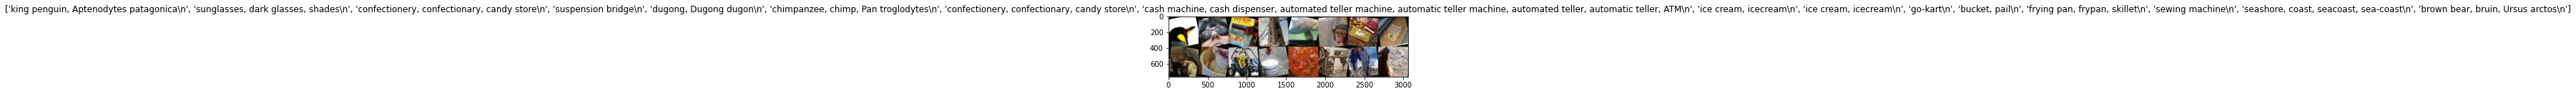

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes, _ = next(iter(dataloaders_dict['train']))

class_names = image_datasets['train'].classes

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[classes_human_readable[class_names[x]] for x in classes])

In [0]:
def visualize_model(model, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels, paths) in enumerate(dataloaders_dict['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot()
                ax.axis('off')
                ax.set_title('path: {}; \n predicted: {}; \n actual: {}'.format(paths[j], classes_human_readable[class_names[preds[j]]], classes_human_readable[class_names[labels[j]]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return

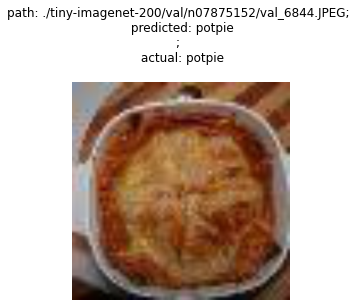

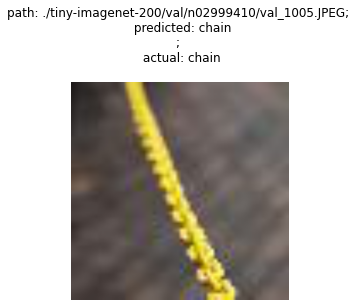

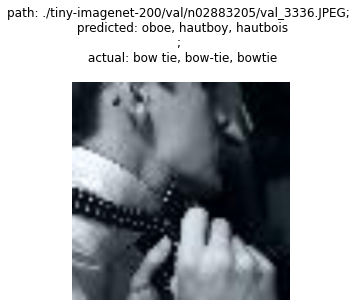

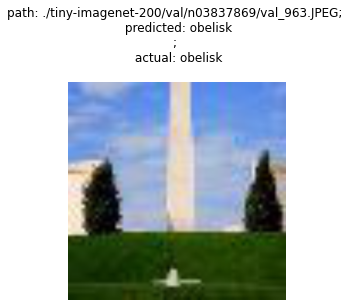

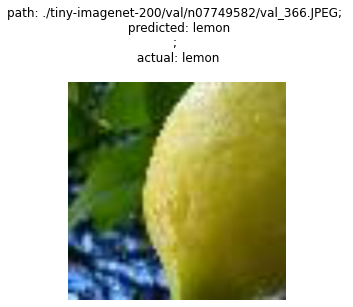

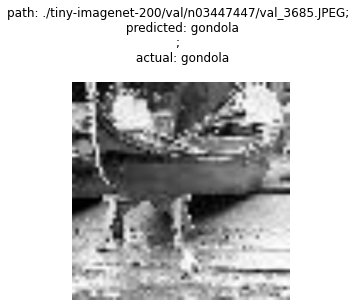

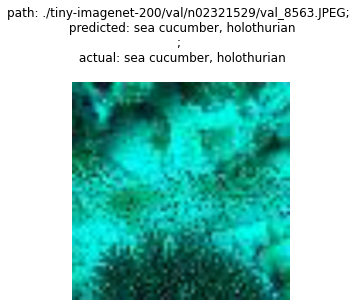

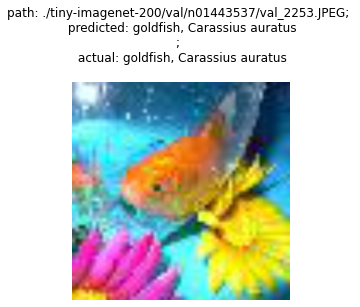

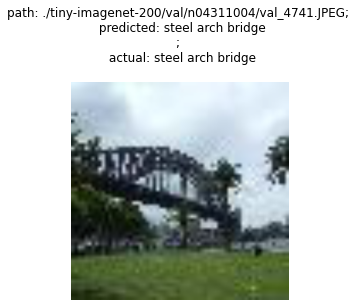

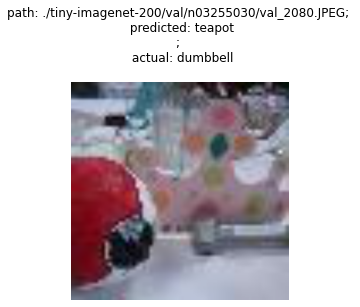

In [12]:
visualize_model(model_ft, num_images=10)

In [0]:
from PIL import Image

datadir = './tiny-imagenet-200/'
traindir = datadir + 'train/'
validdir = datadir + 'val/'


# Empty lists
categories = []
human_readable_categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

# Iterate through each category
for d in os.listdir(traindir):
    categories.append(d)
    human_readable_categories.append(classes_human_readable[d])

    # Number of each image
    train_imgs = os.listdir(traindir + d + '/images/')
    valid_imgs = os.listdir(validdir + d)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))

    # Find stats for train images
    for i in train_imgs:
        img_categories.append(classes_human_readable[d])
        img = Image.open(traindir + d + '/images/' + i)
        img_array = np.array(img)
        # Shape
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])

# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'hr_category': human_readable_categories,
                       'n_train': n_train,
                       'n_valid': n_valid}).\
    sort_values('category')

In [15]:
cat_df.head()

,category,hr_category,n_train,n_valid
126,n01443537,"goldfish, Carassius auratus\n",500,50
47,n01629819,"European fire salamander, Salamandra salamandra\n",500,50
49,n01641577,"bullfrog, Rana catesbeiana\n",500,50
115,n01644900,"tailed frog, bell toad, ribbed toad, tailed to...",500,50
4,n01698640,"American alligator, Alligator mississipiensis\n",500,50


In [0]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

def predict(image_path, model, topk=5):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns

    """
    real_class = image_path.split('/')[-2]

    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)
        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]

        top_hr_classes = [
            model.idx_to_hr_class[class_] for class_ in topclass.cpu().numpy()[0]    
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, top_hr_classes, real_class

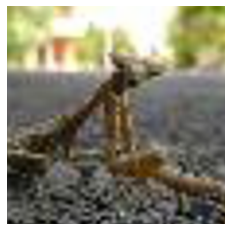

In [17]:
np.random.seed = 100


def random_test_image():
    """Pick a random test image from the test directory"""
    c = np.random.choice(cat_df['category'])
    root = validdir + c + '/'
    img_path = root + np.random.choice(os.listdir(root))
    return img_path


_ = imshow_tensor(process_image(random_test_image()))

In [0]:
def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""

    # Get predictions
    img, ps, classes, hr_classes, y_obs = predict(image_path, model, topk)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index=hr_classes)

    # Show the image
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax=ax)

    # Set title to be the actual class
    ax.set_title(classes_human_readable[y_obs], size=20)

    ax = plt.subplot(1, 2, 2)
    # Plot a bar plot of predictions
    result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

In [0]:
train_on_gpu = torch.cuda.is_available()
model_ft.class_to_idx = image_datasets['train'].class_to_idx
model_ft.idx_to_class = {
    idx: class_
    for class_, idx in model_ft.class_to_idx.items()
}

model_ft.idx_to_hr_class = {
    idx: classes_human_readable[class_]
    for class_, idx in model_ft.class_to_idx.items()
}

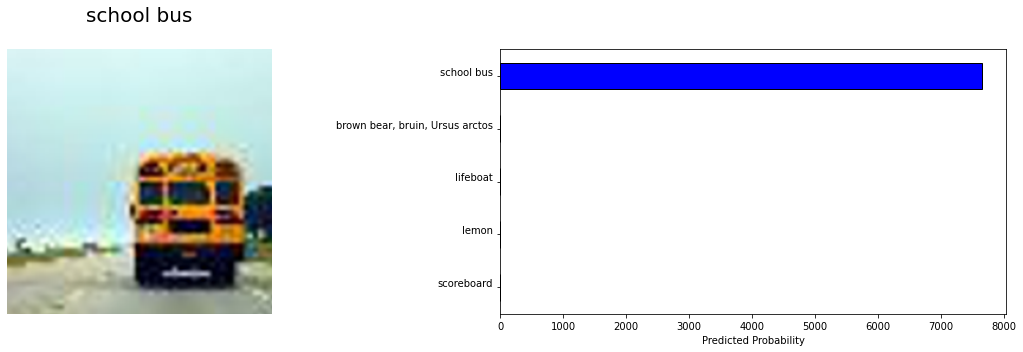

In [20]:
display_prediction(random_test_image(), model_ft, topk=5)

In [0]:
def accuracy(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

def evaluate(model, test_loader, criterion, topk=(1, 5)):
    """Measure the performance of a trained PyTorch model

    Params
    --------
        model (PyTorch model): trained cnn for inference
        test_loader (PyTorch DataLoader): test dataloader
        topk (tuple of ints): accuracy to measure

    Returns
    --------
        results (DataFrame): results for each category

    """

    classes = []
    hr_classes = []
    losses = []
    # Hold accuracy results
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))
    i = 0

    model.eval()
    with torch.no_grad():

        # Testing loop
        for data, targets, _ in test_loader:

            # Tensors to gpu
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            # Raw model output
            out = model(data)
            # Iterate through each example
            for pred, true in zip(out, targets):
                # Find topk accuracy
                acc_results[i, :] = accuracy(
                    pred.unsqueeze(0), true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                hr_classes.append(model.idx_to_hr_class[true.item()])
                # Calculate the loss
                loss = criterion(pred.view(1, num_classes), true.view(1))
                losses.append(loss.item())
                i += 1

    # Send results to a dataframe and calculate average across classes
    results = pd.DataFrame(acc_results, columns=[f'top{i}' for i in topk])
    results['class'] = classes
    results['hr_class'] = hr_classes
    results['loss'] = losses
    results = results.groupby([classes, hr_classes]).mean()

    return results.reset_index().rename(columns={'level_0': 'class', 'level_1': 'hr_class'})

def get_stats(model, test_loader, criterion, topk=(1, 5)):
    """Measure the performance of a trained PyTorch model

    Params
    --------
        model (PyTorch model): trained cnn for inference
        test_loader (PyTorch DataLoader): test dataloader
        topk (tuple of ints): accuracy to measure

    Returns
    --------
        results (DataFrame): results for each category

    """

    true_classes = []
    true_hr_classes = []
    pred_classes = []
    pred_hr_classes = []
    # Hold accuracy results
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))

    model.eval()
    with torch.no_grad():

        # Testing loop
        for data, targets, paths in test_loader:

            # Tensors to gpu
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            # Raw model output
            out = model(data)
            # Iterate through each example
            for pred, true, path in zip(out, targets, paths):                
                true_classes.append(model.idx_to_class[true.item()])
                true_hr_classes.append(model.idx_to_hr_class[true.item()])


                # Find the topk predictions
                ps = torch.exp(pred.unsqueeze(0))
                _, topclass = ps.topk(max(topk), dim=1)

                # top_class = true.item() if true.item() in topclass.cpu().numpy()[0] else topclass.cpu().numpy()[0][0] # uncomment line below for top-1
                top_class = topclass.cpu().numpy()[0][0] # uncomment line above for top-5

                pred_classes.append(model.idx_to_class[top_class])
                pred_hr_classes.append(model.idx_to_hr_class[top_class])

    # Send results to a dataframe and calculate average across classes
    results = pd.DataFrame()
    results['true_class'] = true_classes
    results['true_hr_class'] = true_hr_classes
    results['pred_class'] = pred_classes
    results['pred_hr_class'] = pred_hr_classes

    return results

In [22]:
criterion = nn.NLLLoss()
# Evaluate the model on all the training data
stats = get_stats(model_ft, dataloaders_dict['val'], criterion)
stats.head()

,true_class,true_hr_class,pred_class,pred_hr_class
0,n01774750,tarantula\n,n01774750,tarantula\n
1,n02841315,"binoculars, field glasses, opera glasses\n",n02841315,"binoculars, field glasses, opera glasses\n"
2,n04399382,"teddy, teddy bear\n",n04399382,"teddy, teddy bear\n"
3,n06596364,comic book\n,n06596364,comic book\n
4,n02002724,"black stork, Ciconia nigra\n",n02002724,"black stork, Ciconia nigra\n"


In [23]:
misclassified = stats[stats['true_class'] != stats['pred_class']]
misclassified.groupby('true_class').agg('count').sort_values('pred_class')

,true_hr_class,pred_class,pred_hr_class
true_class,,,
n01443537,1,1,1
n03014705,1,1,1
n02802426,1,1,1
n03444034,1,1,1
n02509815,1,1,1
...,...,...,...
n04371430,14,14,14
n09332890,14,14,14
n04376876,16,16,16


In [0]:
misclassified = misclassified.set_index('true_class')

In [25]:
misclassified.loc['n04507155']

,true_hr_class,pred_class,pred_hr_class
true_class,,,
n04507155,umbrella\n,n03980874,poncho\n
n04507155,umbrella\n,n09428293,"seashore, coast, seacoast, sea-coast\n"
n04507155,umbrella\n,n04356056,"sunglasses, dark glasses, shades\n"
n04507155,umbrella\n,n04259630,sombrero\n
n04507155,umbrella\n,n02788148,"bannister, banister, balustrade, balusters, ha..."
n04507155,umbrella\n,n02730930,apron\n
n04507155,umbrella\n,n04259630,sombrero\n
n04507155,umbrella\n,n04501370,turnstile\n
n04507155,umbrella\n,n04259630,sombrero\n


## Worst categories

In [26]:
criterion = nn.NLLLoss()
# Evaluate the model on all the training data
results = evaluate(model_ft, dataloaders_dict['val'], criterion)
results.head()

,class,hr_class,top1,top5,loss
0,n01443537,"goldfish, Carassius auratus\n",98.0,100.0,-10.125678
1,n01629819,"European fire salamander, Salamandra salamandra\n",94.0,100.0,-9.853207
2,n01641577,"bullfrog, Rana catesbeiana\n",86.0,98.0,-9.743448
3,n01644900,"tailed frog, bell toad, ribbed toad, tailed to...",74.0,100.0,-9.738558
4,n01698640,"American alligator, Alligator mississipiensis\n",88.0,100.0,-9.194751


In [27]:
top1 = results['top1'].mean()
top5 = results['top5'].mean()
loss = results['loss'].mean()

print(f'Final test cross entropy per image = {loss:.4f}.')
print(f'Final test top 1 accuracy = {top1:.2f}%')
print(f'Final test top 5 accuracy = {top5:.2f}%')

Final test cross entropy per image = -10.4463.
Final test top 1 accuracy = 89.13%
Final test top 5 accuracy = 97.89%


In [0]:
def display_category(model, category, n=4):
    """Display predictions for a category    
    """
    category_results = results.loc[results['class'] == category]
    print(category_results.iloc[:, :6], '/n')

    images = np.random.choice(
        os.listdir(validdir + category + '/'), size=4, replace=False)

    for img in images:
        display_prediction(validdir + category + '/' + img, model, 5)

In [29]:
results.sort_values('top5').head(10)

,class,hr_class,top1,top5,loss
159,n04376876,syringe\n,68.0,88.0,-8.385550
139,n04067472,reel\n,84.0,90.0,-12.125411
175,n04597913,wooden spoon\n,82.0,90.0,-9.243500
19,n01984695,"spiny lobster, langouste, rock lobster, crawfi...",82.0,92.0,-8.764970
156,n04356056,"sunglasses, dark glasses, shades\n",82.0,92.0,-8.125362
172,n04560804,water jug\n,78.0,92.0,-9.056289
181,n07695742,pretzel\n,82.0,92.0,-10.162013
79,n02906734,broom\n,82.0,92.0,-10.745573
140,n04070727,"refrigerator, icebox\n",88.0,92.0,-10.318766
84,n02950826,cannon\n,80.0,92.0,-9.125582


In [30]:
results.sort_values('top1').head(10)

,class,hr_class,top1,top5,loss
177,n07579787,plate\n,62.0,98.0,-9.338906
132,n03976657,pole\n,64.0,94.0,-9.186513
159,n04376876,syringe\n,68.0,88.0,-8.385550
197,n09332890,"lakeside, lakeshore\n",72.0,96.0,-9.098663
158,n04371430,"swimming trunks, bathing trunks\n",72.0,98.0,-9.499138
32,n02124075,Egyptian cat\n,74.0,96.0,-9.753929
3,n01644900,"tailed frog, bell toad, ribbed toad, tailed to...",74.0,100.0,-9.738558
196,n09256479,coral reef\n,74.0,98.0,-8.895994
198,n09428293,"seashore, coast, seacoast, sea-coast\n",74.0,100.0,-8.479639
195,n09246464,"cliff, drop, drop-off\n",74.0,96.0,-8.775882


         class    hr_class  top1  top5      loss
168  n04507155  umbrella\n  80.0  94.0 -9.634714 /n


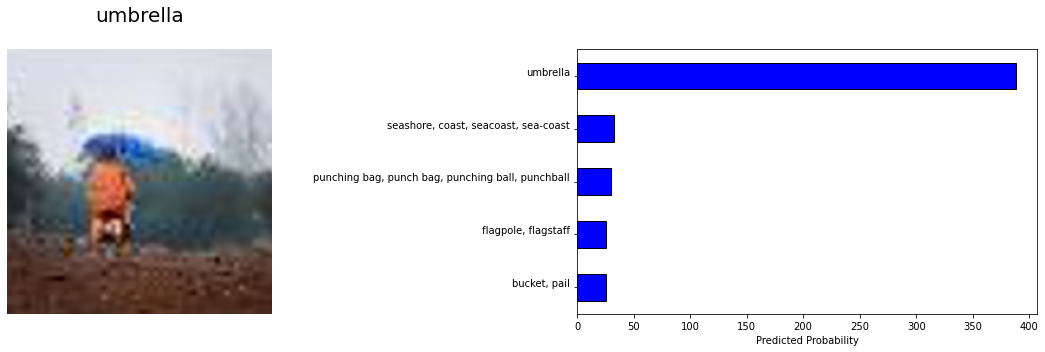

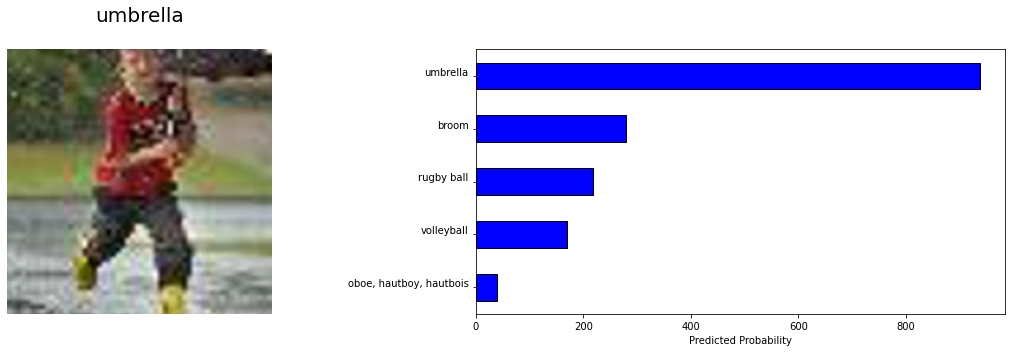

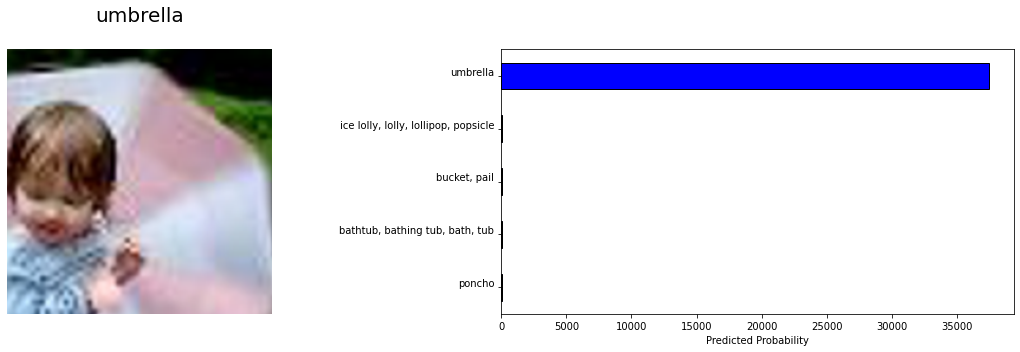

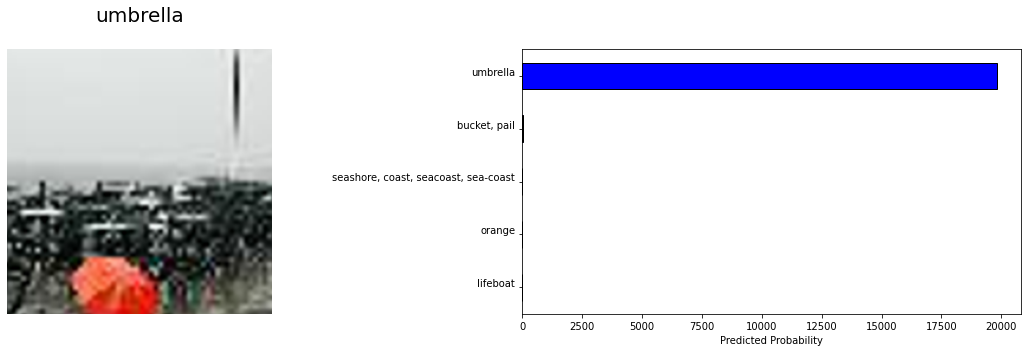

In [32]:
display_category(model_ft, 'n04507155') # rerun if there's an error

## Filters

Credits: https://github.com/Niranjankumar-c/DeepLearning-PadhAI/blob/master/DeepLearning_Materials/6_VisualizationCNN_Pytorch/CNNVisualisation.ipynb

In [0]:
def plot_filters_single_channel_big(t):
    
    #setting the rows and columns
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]
    
    
    npimg = np.array(t.cpu().numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    
    npimg = npimg.T
    
    fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))    
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)

def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.cpu().numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].cpu().numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].cpu().numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()

def plot_weights(model, layer_num, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
  layer = model._blocks[layer_num]._depthwise_conv
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = model._blocks[layer_num]._depthwise_conv.weight.data
    print(weight_tensor.shape)
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor)
        
    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
      else:
        print("Can only plot weights with three channels with single channel = False")
        
  else:
    print("Can only visualize layers which are convolutional")

torch.Size([48, 1, 3, 3])


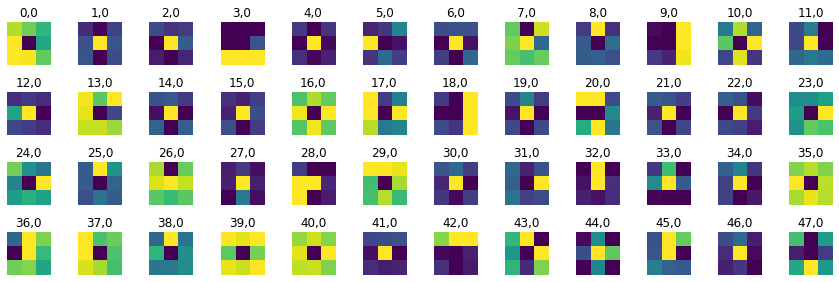

In [34]:
plot_weights(model_ft, 0, single_channel=True)